In [1]:
# format tables
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as grdspec
import pandas as pd

In [66]:
# create mapping table to Quandl symbols: continuous futures price, COT report, and COT Legacy report
commodity = ['silver','gold','copper','crude','natgas','platinum', 'cotton','gasoline']
symbols = [
    ['CHRIS/CME_SI1','CFTC/SI_FO_ALL','CFTC/SI_FO_L_ALL'],
    ['CHRIS/CME_GC1','CFTC/GC_FO_ALL','CFTC/GC_FO_L_ALL'],
    ['CHRIS/CME_HG1','CFTC/HG_FO_ALL','CFTC/HG_FO_L_ALL'],
    ['CHRIS/CME_CL1','CFTC/CL_FO_ALL','CFTC/CL_FO_L_ALL'],
    ['CHRIS/CME_NG1','CFTC/NG_FO_ALL','CFTC/NG_FO_L_ALL'],
    ['CHRIS/CME_PL1','CFTC/PL_FO_ALL','CFTC/PL_FO_L_ALL'],
    ['CHRIS/ICE_CT1','CFTC/CT_FO_ALL','CFTC/CT_FO_L_ALL'],
    ['CHRIS/CME_RB1','CFTC/RB_FO_ALL','CFTC/RB_FO_L_ALL']
]

mapping = dict(list(zip(commodity,symbols)))


# Import data from Quandl


In [4]:
import quandl
quandl.ApiConfig.api_key = 'wxychbrgu7o7x3MRq4Hx'

In [16]:
symbol = mapping['silver']

print ('retrieving price data')
priceData = quandl.get(symbol[0])
print ('retrieving COT data')
cotData = quandl.get(symbol[1])
print ('retrieving COT legacy data')
cotLegacy = quandl.get(symbol[2])

# rename Producer columns
for i, header in enumerate(list(cotData)):
    if list(cotData)[i].startswith('Producer') & list(cotData)[i].endswith('Longs'):
        cotData = cotData.rename(columns={
            list(cotData)[i]:'Producer Longs'
        })
    elif list(cotData)[i].startswith('Producer') & list(cotData)[i].endswith('Shorts'):
        cotData = cotData.rename(columns={
            list(cotData)[i]:'Producer Shorts'
        })


retrieving price data
retrieving COT data
retrieving COT legacy data


## Merge COT data table and Settle Price

In [17]:
price = priceData[['Settle']]
price = price.fillna(method = 'ffill')
cotData = cotData.merge(price, how='left', left_index=True, right_index=True)
cotLegacy = cotLegacy.merge(price, how='left', left_index=True, right_index=True)



## Compute COT net position rolling percentile (adjusted by open interest)


     Open Interest    MMNet   MMNetOI  ProdNet  ProdNetOI   CommNet  \
547       176146.0  40625.0  0.230633 -48605.0  -0.275936  -76469.0   
548       180788.0  45980.0  0.254331 -52617.0  -0.291043  -81947.0   
549       180884.0  43359.0  0.239706 -48613.0  -0.268752  -74801.0   
550       179624.0  39098.0  0.217666 -48551.0  -0.270292  -74627.0   
551       180740.0  41999.0  0.232372 -49480.0  -0.273763  -76289.0   
552       182082.0  46169.0  0.253562 -49057.0  -0.269423  -79287.0   
553       189926.0  50752.0  0.267220 -51396.0  -0.270611  -81614.0   
554       195310.0  55109.0  0.282162 -53746.0  -0.275183  -82733.0   
555       203688.0  62964.0  0.309120 -59108.0  -0.290189  -89448.0   
556       212440.0  64392.0  0.303107 -59802.0  -0.281501  -92572.0   
557       214400.0  70746.0  0.329972 -61647.0  -0.287533  -98957.0   
558       228042.0  75475.0  0.330970 -63266.0  -0.277431 -101734.0   
559       214558.0  83854.0  0.390822 -64994.0  -0.302920 -107770.0   
560   

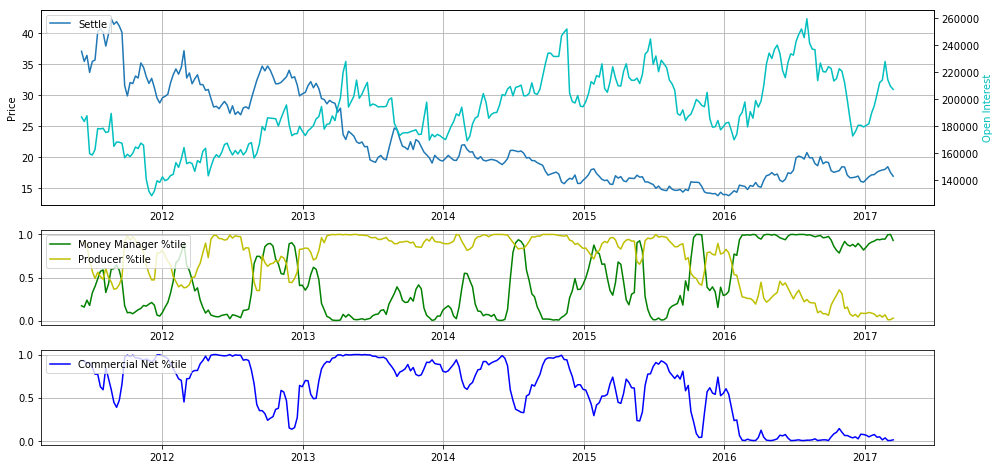

In [29]:
roll_period = 260

def rank(array):
    # wrapper for pd.Series.rank function
    s = pd.Series(array)
    return s.rank()[len(s)-1]

cotData['MMNet'] = (cotData['Money Manager Longs']-cotData['Money Manager Shorts'])
cotData['MMNetOI'] = (cotData['Money Manager Longs']-cotData['Money Manager Shorts']) / cotData['Open Interest']
# 5-year (260 weeks) rolling percentile (adjusted by open interest)
cotData['MMNetOIPrctile'] = (cotData['MMNetOI'].rolling(window=roll_period).apply(rank)) / roll_period

cotData['ProdNet'] = (cotData['Producer Longs']-cotData['Producer Shorts'])
cotData['ProdNetOI'] = (cotData['Producer Longs']-cotData['Producer Shorts']) / cotData['Open Interest']
cotData['ProdNetOIPrctile'] = (cotData['ProdNetOI'].rolling(window=roll_period).apply(rank)) / roll_period

cotLegacy['CommNet'] = (cotLegacy['Commercial Long']-cotLegacy['Commercial Short'])
cotLegacy['CommNetOI'] = (cotLegacy['Commercial Long']-cotLegacy['Commercial Short']) / cotData['Open Interest']
cotLegacy['CommNetOIPrctile'] = (cotLegacy['CommNetOI'].rolling(window=roll_period).apply(rank)) / roll_period

displayTable = cotData.merge(cotLegacy)
print (displayTable[['Open Interest','MMNet','MMNetOI','ProdNet','ProdNetOI','CommNet','CommNetOI','Settle']].tail(15))

s1 = cotData['Settle'].tail(len(cotData) - roll_period)
s2 = cotData['MMNetOIPrctile'].tail(len(cotData) - roll_period)
s3 = cotData['ProdNetOIPrctile'].tail(len(cotData) - roll_period)
s4 = cotLegacy['CommNetOIPrctile'].tail(len(cotData) - roll_period)  # note: use length of cotData, not cotLegacy
s5 = cotData['Open Interest'].tail(len(cotData) - roll_period)

fig = plt.figure(figsize=(16, 8)) 
gs = grdspec.GridSpec(3, 1, height_ratios=[3.5, 1.7, 1.7])  # 3 rows, 1 column
ax0 = plt.subplot(gs[0])
ax0.plot(s1)
ax0.legend(loc='upper left')
ax0.set_ylabel('Price')
ax0.grid()
ax1 = plt.subplot(gs[1])
ax1.plot(s2, label='Money Manager %tile', color='g')
ax1.plot(s3, label='Producer %tile', color='y')
ax1.legend(loc='upper left')
ax1.grid()
ax2 = plt.subplot(gs[2])
ax2.plot(s4, label='Commercial Net %tile', color='b')
ax2.legend(loc='upper left')
ax2.grid()
#ax3 = plt.subplot(gs[3])
ax3 = ax0.twinx()
ax3.plot(s5, label='Open Interest', color='c')
ax3.set_ylabel('Open Interest', color='c')
#ax3.legend(loc='upper left')
#ax3.grid()
plt.show()

## Plot COT positioning by trader categories

**Money Manager Long/Shorts**

Latest Money Manager Positions: 
             MoneyManagerNet  Money Manager Longs  Money Manager Shorts
Date                                                                  
2017-02-14         390338.0             432944.0               42606.0
2017-02-21         413637.0             453030.0               39393.0
2017-02-28         386707.0             435475.0               48768.0
2017-03-07         375558.0             424549.0               48991.0
2017-03-14         288774.0             386941.0               98167.0


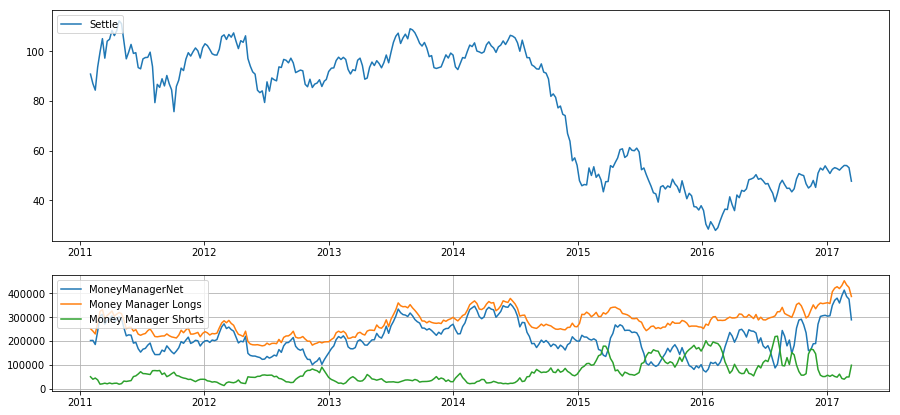

In [26]:
period = 320

s1 = cotData['Settle'].tail(period)
s2 = cotData['MoneyManagerNet'].tail(period)
s3 = cotData['Money Manager Longs'].tail(period)
s4 = cotData['Money Manager Shorts'].tail(period)
print ('Latest Money Manager Positions: \n', cotData[['MoneyManagerNet','Money Manager Longs','Money Manager Shorts']].tail(5))

fig = plt.figure(figsize=(15, 7)) 
gs = grdspec.GridSpec(2, 1, height_ratios=[2, 1]) 
ax0 = plt.subplot(gs[0])
ax0.plot(s1)
ax0.legend(loc='upper left')
ax1 = plt.subplot(gs[1])
ax1.plot(s2)
ax1.plot(s3)
ax1.plot(s4)
ax1.legend(loc='upper left')
plt.grid()
plt.show()

**Producer Long/Shorts**

Latest Producer Positions: 
             ProducerNet  Producer Longs  Producer Shorts
Date                                                    
2017-02-14    -278856.0        477018.0         755874.0
2017-02-21    -291253.0        411332.0         702585.0
2017-02-28    -291195.0        410517.0         701712.0
2017-03-07    -294095.0        416686.0         710781.0
2017-03-14    -264297.0        475439.0         739736.0


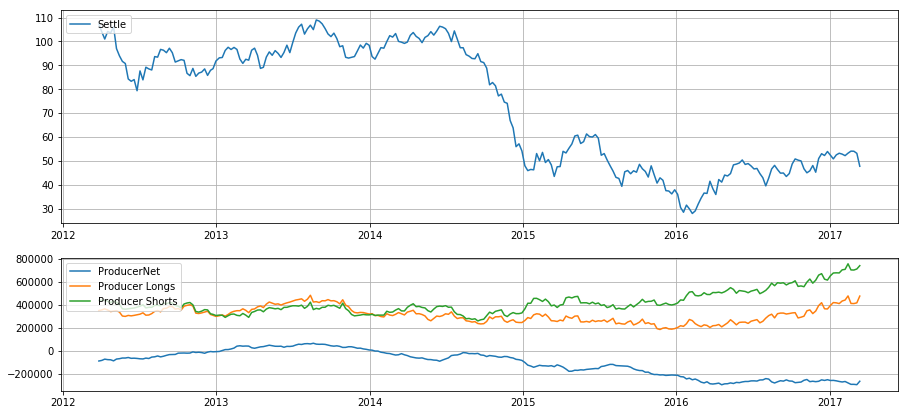

In [27]:
period = 260
s1 = cotData['Settle'].tail(period)
s2 = cotData['ProducerNet'].tail(period)
s3 = cotData['Producer Longs'].tail(period)
s4 = cotData['Producer Shorts'].tail(period)
print ('Latest Producer Positions: \n', cotData[['ProducerNet','Producer Longs','Producer Shorts']].tail(5))

fig = plt.figure(figsize=(15, 7)) 
gs = grdspec.GridSpec(2, 1, height_ratios=[8, 5]) 
ax0 = plt.subplot(gs[0])
ax0.grid()
ax0.plot(s1)
ax0.legend(loc='upper left')
ax1 = plt.subplot(gs[1])
ax1.grid()
ax1.plot(s2)
ax1.plot(s3)
ax1.plot(s4)
ax1.legend(loc='upper left')
plt.show()

**Commercial Net position (Legacy)**

            Settle  CommercialNet
Date                             
2017-02-14   53.20      -575328.0
2017-02-21   54.06      -601016.0
2017-02-28   54.01      -585712.0
2017-03-07   53.14      -585181.0
2017-03-14   47.72      -520463.0


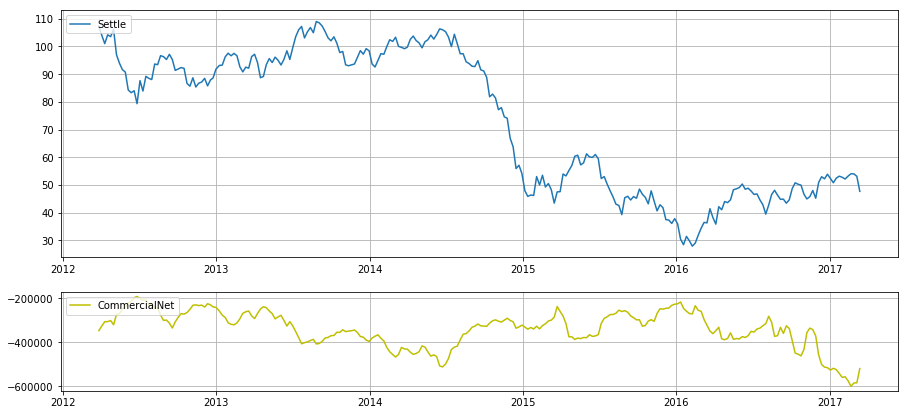

In [28]:
period = 260
s1 = cotLegacy['Settle'].tail(period)
s2 = cotLegacy['CommercialNet'].tail(period)
print (cotLegacy[['Settle','CommercialNet']].tail(5))

fig = plt.figure(figsize=(15, 7)) 
gs = grdspec.GridSpec(2, 1, height_ratios=[5, 2]) 
ax0 = plt.subplot(gs[0])
ax0.grid()
ax0.plot(s1)
ax0.legend(loc='upper left')
ax1 = plt.subplot(gs[1])
ax1.grid()
ax1.plot(s2, color='y')
ax1.legend(loc='upper left')
plt.show()

**Plot Price and Open Interest**

            Open Interest  Settle
Date                             
2017-02-14      2913801.0   53.20
2017-02-21      2727947.0   54.06
2017-02-28      2765071.0   54.01
2017-03-07      2803226.0   53.14
2017-03-14      3052948.0   47.72


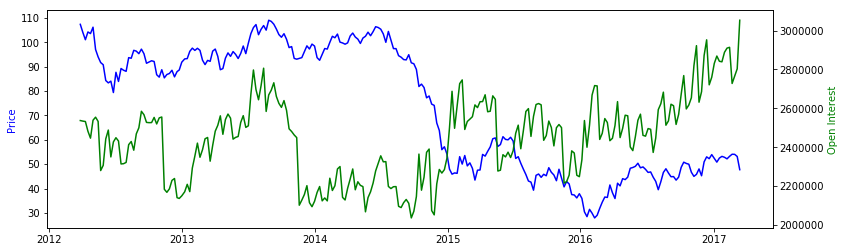

In [29]:
period = 260
cotprice = cotData[['Open Interest','Settle']].tail(period)
print (cotData[['Open Interest','Settle']].tail(5))

fig, ax1 = plt.subplots(figsize=(13,4))

ax1.plot(cotprice['Settle'], color='b')
ax1.set_ylabel('Price', color='b')
ax2 = ax1.twinx()    # Axes.twinx method allows sharing of x-axis with different scales
ax2.plot(cotprice['Open Interest'], color='g')
ax2.set_ylabel('Open Interest', color='g')
plt.show()

## Rewrite in function forms ##

In [73]:
def rank(array):
    # wrapper for pd.Series.rank function
    s = pd.Series(array)
    return s.rank()[len(s)-1]

def cotFunction1(sym):
    
    # create mapping table to Quandl symbols: continuous futures price, COT report, and COT Legacy report
    commodity = ['silver','gold','copper','crude','natgas','platinum', 'cotton','gasoline']
    symbols = [
        ['CHRIS/CME_SI1','CFTC/SI_FO_ALL','CFTC/SI_FO_L_ALL'],
        ['CHRIS/CME_GC1','CFTC/GC_FO_ALL','CFTC/GC_FO_L_ALL'],
        ['CHRIS/CME_HG1','CFTC/HG_FO_ALL','CFTC/HG_FO_L_ALL'],
        ['CHRIS/CME_CL1','CFTC/CL_FO_ALL','CFTC/CL_FO_L_ALL'],
        ['CHRIS/CME_NG1','CFTC/NG_FO_ALL','CFTC/NG_FO_L_ALL'],
        ['CHRIS/CME_PL1','CFTC/PL_FO_ALL','CFTC/PL_FO_L_ALL'],
        ['CHRIS/ICE_CT1','CFTC/CT_FO_ALL','CFTC/CT_FO_L_ALL'],
        ['CHRIS/CME_RB1','CFTC/RB_FO_ALL','CFTC/RB_FO_L_ALL']
    ]

    mapping = dict(list(zip(commodity,symbols)))

    symbol = mapping[sym]

    print ('retrieving price data')
    priceData = quandl.get(symbol[0])
    print ('retrieving COT data')
    cotData = quandl.get(symbol[1])
    print ('retrieving COT legacy data')
    cotLegacy = quandl.get(symbol[2])

    # rename Producer columns
    for i, header in enumerate(list(cotData)):
        if list(cotData)[i].startswith('Producer') & list(cotData)[i].endswith('Longs'):
            cotData = cotData.rename(columns={
                list(cotData)[i]:'Producer Longs'
            })
        elif list(cotData)[i].startswith('Producer') & list(cotData)[i].endswith('Shorts'):
            cotData = cotData.rename(columns={
                list(cotData)[i]:'Producer Shorts'
            })

    # Merge COT data table and Settle Price
    price = priceData[['Settle']]
    price = price.fillna(method = 'ffill')
    cotData = cotData.merge(price, how='left', left_index=True, right_index=True)
    cotLegacy = cotLegacy.merge(price, how='left', left_index=True, right_index=True)

    # create new columns of rolling data
    roll_period = 260

    cotData['MMNet'] = (cotData['Money Manager Longs']-cotData['Money Manager Shorts'])
    cotData['MMNetOI'] = (cotData['Money Manager Longs']-cotData['Money Manager Shorts']) / cotData['Open Interest']
    # 5-year (260 weeks) rolling percentile (adjusted by open interest)
    cotData['MMNetOIPrctile'] = (cotData['MMNetOI'].rolling(window=roll_period).apply(rank)) / roll_period

    cotData['ProdNet'] = (cotData['Producer Longs']-cotData['Producer Shorts'])
    cotData['ProdNetOI'] = (cotData['Producer Longs']-cotData['Producer Shorts']) / cotData['Open Interest']
    cotData['ProdNetOIPrctile'] = (cotData['ProdNetOI'].rolling(window=roll_period).apply(rank)) / roll_period

    cotLegacy['CommNet'] = (cotLegacy['Commercial Long']-cotLegacy['Commercial Short'])
    cotLegacy['CommNetOI'] = (cotLegacy['Commercial Long']-cotLegacy['Commercial Short']) / cotData['Open Interest']
    cotLegacy['CommNetOIPrctile'] = (cotLegacy['CommNetOI'].rolling(window=roll_period).apply(rank)) / roll_period

    displayTable = cotData[['Open Interest','MMNet','MMNetOI','ProdNet','ProdNetOI','Settle']].tail(15)
    print (displayTable[['Open Interest','MMNet','MMNetOI','ProdNet','ProdNetOI','Settle']].tail(15))

    s1 = cotData['Settle'].tail(len(cotData) - roll_period)
    s2 = cotData['MMNetOIPrctile'].tail(len(cotData) - roll_period)
    s3 = cotData['ProdNetOIPrctile'].tail(len(cotData) - roll_period)
    s4 = cotLegacy['CommNetOIPrctile'].tail(len(cotData) - roll_period)  # note: use length of cotData, not cotLegacy
    s5 = cotData['Open Interest'].tail(len(cotData) - roll_period)

    fig = plt.figure(figsize=(13, 6)) 
    gs = grdspec.GridSpec(3, 1, height_ratios=[3.5, 1.7, 1.7])  # 3 rows, 1 column
    ax0 = plt.subplot(gs[0])
    ax0.plot(s1)
    ax0.legend(loc='upper left')
    ax0.set_ylabel('Price')
    ax0.grid()
    ax1 = plt.subplot(gs[1])
    ax1.plot(s2, label='Money Manager %tile', color='g')
    ax1.plot(s3, label='Producer %tile', color='y')
    ax1.legend(loc='upper left')
    ax1.grid()
    ax2 = plt.subplot(gs[2])
    ax2.plot(s4, label='Commercial Net %tile', color='b')
    ax2.legend(loc='upper left')
    ax2.grid()
    ax3 = ax0.twinx()
    ax3.plot(s5, label='Open Interest', color='c')
    ax3.set_ylabel('Open Interest', color='c')
    plt.show()
    
    return displayTable, fig

retrieving price data
retrieving COT data
retrieving COT legacy data
            Open Interest    MMNet   MMNetOI   ProdNet  ProdNetOI  Settle
Date                                                                     
2016-12-06       389745.0  40473.0  0.103845 -121318.0  -0.311275  1.5359
2016-12-13       387694.0  38625.0  0.099628 -111644.0  -0.287969  1.5507
2016-12-20       395964.0  42879.0  0.108290 -113274.0  -0.286071  1.5936
2016-12-27       405803.0  50091.0  0.123437 -120601.0  -0.297191  1.6528
2017-01-03       411238.0  61446.0  0.149417 -131436.0  -0.319611  1.6218
2017-01-10       408463.0  63443.0  0.155321 -136356.0  -0.333827  1.5467
2017-01-17       431102.0  63678.0  0.147710 -138492.0  -0.321251  1.6004
2017-01-24       447146.0  61511.0  0.137564 -138458.0  -0.309648  1.5759
2017-01-31       429971.0  56069.0  0.130402 -137330.0  -0.319394  1.5256
2017-02-07       433334.0  48763.0  0.112530 -124767.0  -0.287923  1.4875
2017-02-14       432200.0  49374.0  0.11423

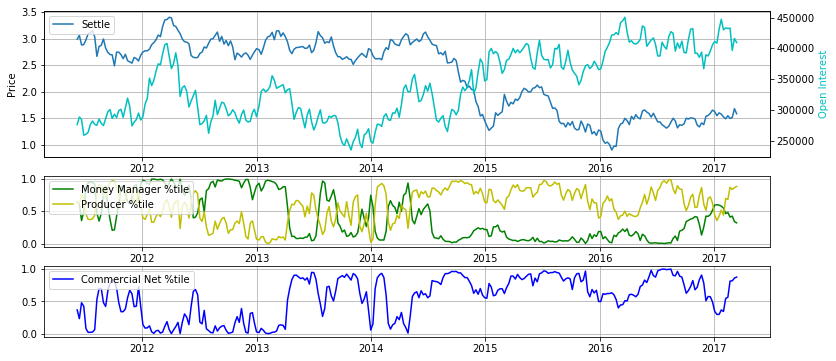

In [74]:
tbl, cotFig = cotFunction1('gasoline')
#cotFig.suptitle('Silver')
#cotFig.savefig(os.path.abspath('pics\\COT_data') + '.png', format = 'png')